In [21]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [22]:
datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
featurefolder = 'ressummaryfeaturesxgbNorbits10000.0Nout1000/'
features = None

In [23]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

In [24]:
trainX.shape

(7999, 58)

In [25]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

In [26]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.9301380400000001                                  
ERROR                                               
0.00513922353884161                                 
HOLDOUT SCORE                                       
0.944408407754026                                   
SCORE:                                                                         
0.9306958599999999                                                             
ERROR                                                                          
0.004470925321253949                                                           
HOLDOUT SCORE                                                                  
0.9440353013167047                                                             
SCORE:                                                                         
0.9322621200000001                                                             
ERROR                                     

ERROR                                                                          
0.005233196914227973                                                           
HOLDOUT SCORE                                                                  
0.9398696851336403                                                             
SCORE:                                                                         
0.92660082                                                                     
ERROR                                                                          
0.005766306510548804                                                           
HOLDOUT SCORE                                                                  
0.9413456409892578                                                             
SCORE:                                                                         
0.9301515599999999                                                             
ERROR                                   

ERROR                                                                          
0.00336847062739326                                                            
HOLDOUT SCORE                                                                  
0.9467274954739466                                                             
SCORE:                                                                         
0.93054638                                                                     
ERROR                                                                          
0.005200068768109957                                                           
HOLDOUT SCORE                                                                  
0.9431655642395533                                                             
SCORE:                                                                         
0.89527492                                                                     
ERROR                                   

In [27]:
best

{'x_learning_rate': 0.17049883400833232,
 'x_max_depth': 15,
 'x_min_child': 4.0,
 'x_pos_weight': 14.972737650672839,
 'x_subsample': 0.9198878331757864,
 'x_tree_colsample': 0.9109979380441462}

In [28]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.953216+0.00271983	test-auc:0.903489+0.00724845
[1]	train-auc:0.971202+0.00257553	test-auc:0.915728+0.00595352
[2]	train-auc:0.978287+0.000820872	test-auc:0.921345+0.00601962
[3]	train-auc:0.982955+0.000892348	test-auc:0.926625+0.00633541
[4]	train-auc:0.986418+0.000903439	test-auc:0.929194+0.00690917
[5]	train-auc:0.989336+0.00102152	test-auc:0.930897+0.00796076
[6]	train-auc:0.991545+0.00116337	test-auc:0.933189+0.00717073
[7]	train-auc:0.993345+0.000936111	test-auc:0.935516+0.00641731
[8]	train-auc:0.994649+0.000834124	test-auc:0.937409+0.0056401
[9]	train-auc:0.995687+0.000584881	test-auc:0.938401+0.00626838
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.953216       0.002720       0.903489      0.007248
1        0.971202       0.002576       0.915728      0.005954
2        0.978287       0.000821       0.921345      0.006020
3        0.982955       0.000892       0.926625      0.006335
4        0.986418       0.000903       0.929194      0.

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.8488668289803917


In [29]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.9109979380441462, gamma=0,
              learning_rate=0.17049883400833232, max_delta_step=0, max_depth=15,
              min_child_weight=4.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=14.972737650672839,
              seed=None, silent=True, subsample=0.9198878331757864)

Text(0.5, 1.0, 'ROC curve (AUC = 0.954)')

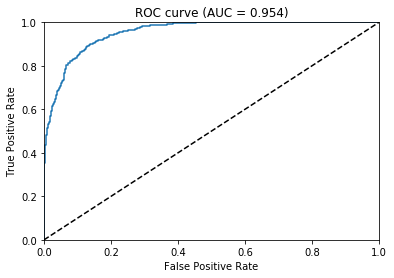

In [30]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [31]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.002750176237896085, recall = 1.0, precision = 0.4586815227483751
Threshold 0.0030854325741529465, recall = 0.9979757085020243, precision = 0.4642184557438795
Threshold 0.00331603130325675, recall = 0.9979757085020243, precision = 0.4708691499522445
Threshold 0.0037937527522444725, recall = 0.9979757085020243, precision = 0.47771317829457366
Threshold 0.004244508687406778, recall = 0.9979757085020243, precision = 0.48475909537856443
Threshold 0.004781506024301052, recall = 0.9979757085020243, precision = 0.49201596806387227
Threshold 0.0057002101093530655, recall = 0.9959514170040485, precision = 0.49848024316109424
Threshold 0.0061778295785188675, recall = 0.9919028340080972, precision = 0.5041152263374485
Threshold 0.007163155358284712, recall = 0.9898785425101214, precision = 0.5109717868338558
Threshold 0.007960300892591476, recall = 0.9878542510121457, precision = 0.5180467091295117
Threshold 0.00913328118622303, recall = 0.9878542510121457, precision = 0.52642934196332

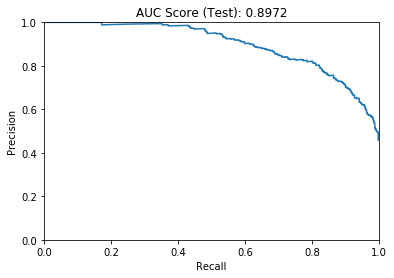

In [32]:
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

(0, 203.50000000000003)

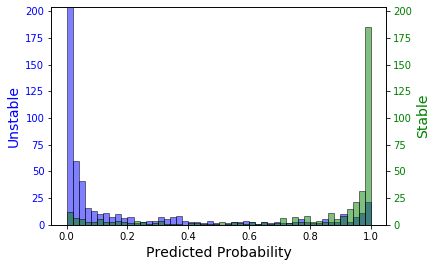

In [13]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,1.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

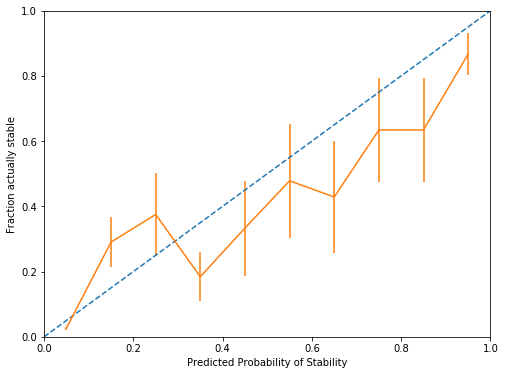

In [14]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

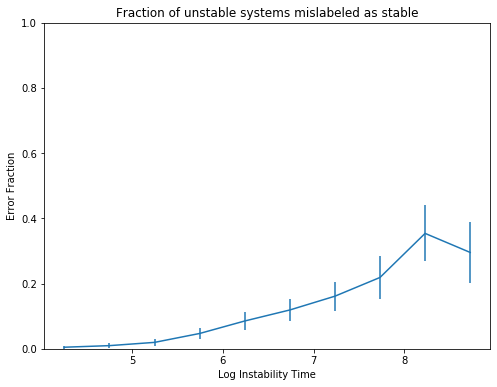

In [15]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

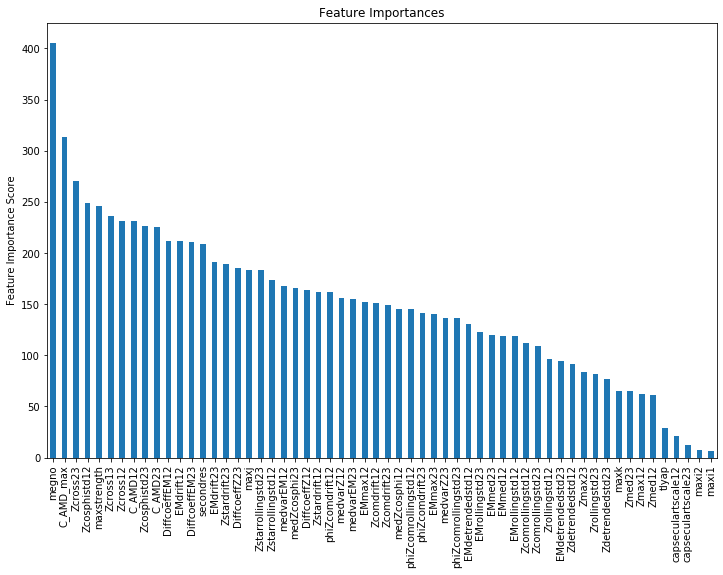

In [16]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [17]:
dill.dump([model, features, featurefolder], open(datapath+"../models/ressummaryfeaturesxgb_resonantAMD.pkl", "wb"))

# slice data between ranges of instability times

# things that are just unstable might be very similar to things that are just stable

# predict at half a billion, then repredict at half a billion whether you'll be unstable at a billion

# do the summary features change with time?

# try training on just unstable systems